### Part A – Question 1: Loading and Preparing the Landsat (Satimage) Data

In this question, we start by loading the **Landsat Satellite dataset**, which contains multispectral pixel data from satellite images.  
Each record corresponds to the **center pixel of a 3×3 neighborhood**, giving us **36 input features** (4 spectral bands × 9 pixels).  
The task is a **multi-class classification problem** with **6 land-cover types**:

| Label | Land-Cover Class               |
|:------:|:------------------------------|
| 1 | Red soil |
| 2 | Cotton crop |
| 3 | Grey soil |
| 4 | Damp grey soil |
| 5 | Soil with vegetation stubble |
| 7 | Very damp grey soil |

> Class **6 (mixture class)** is not included in this dataset.

The dataset comes in two files placed in the same folder as this notebook:
- `sat.trn` → Training data (4435 samples)  
- `sat.tst` → Test data (2000 samples)

As mentioned in the instructions, we won’t use cross-validation; we’ll simply train on the training set and test on the test set.  
Finally, we’ll **standardize the feature values** (zero mean and unit variance) using the training set statistics and apply the same transformation to the test data.  
This ensures that all models trained later in the assignment will receive properly scaled inputs.

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [26]:
# =========================
# Part A – Q1: Data Loading & Standardization
# =========================

# ---- File paths 
TR_PATH = "sat.trn"
TE_PATH = "sat.tst"

# ---- Column names: 36 features + 1 label
feat_cols = [f"f{i:02d}" for i in range(1, 37)]
col_names = feat_cols + ["label"]

# ---- Load data 
tr_df = pd.read_csv(TR_PATH, delim_whitespace=True, header=None, names=col_names)
te_df = pd.read_csv(TE_PATH, delim_whitespace=True, header=None, names=col_names)

# ---- Split features/labels
X_tr = tr_df[feat_cols].astype(np.float32).values
y_tr = tr_df["label"].astype(int).values

X_te = te_df[feat_cols].astype(np.float32).values
y_te = te_df["label"].astype(int).values

# ---- Standardization: fit on TRAIN only, apply to both
scaler = StandardScaler()
X_tr_std = scaler.fit_transform(X_tr)
X_te_std = scaler.transform(X_te)

# ---- Quick summary prints for verification
print("Shapes:")
print(f"  Train: X={X_tr_std.shape}, y={y_tr.shape}")
print(f"  Test : X={X_te_std.shape}, y={y_te.shape}")

print("\nLabel distribution (train):")
print(pd.Series(y_tr).value_counts().sort_index())

print("\nLabel distribution (test):")
print(pd.Series(y_te).value_counts().sort_index())

# ---- Variables for later parts
data_bundle = {
    "X_tr": X_tr_std, "y_tr": y_tr,
    "X_te": X_te_std, "y_te": y_te,
    "scaler": scaler,
    "feature_names": feat_cols,
    "class_names": {1:"red soil", 2:"cotton crop", 3:"grey soil",
                    4:"damp grey soil", 5:"soil+stubble", 7:"very damp grey soil"}
}

Shapes:
  Train: X=(4435, 36), y=(4435,)
  Test : X=(2000, 36), y=(2000,)

Label distribution (train):
1    1072
2     479
3     961
4     415
5     470
7    1038
Name: count, dtype: int64

Label distribution (test):
1    461
2    224
3    397
4    211
5    237
7    470
Name: count, dtype: int64


The dataset loaded correctly with 4435 training samples and 2000 testing samples, each having 36 input features.  
The class distribution indicates that all six classes are present, but not perfectly balanced — for example, classes 1 and 7 have more instances than classes 2 and 4.  
This mild imbalance may affect how some models perform and will be important when analyzing precision-recall curves later in the assignment.

---
### Part A – Question 2: Train–Test Split Confirmation

The dataset already comes with a predefined split — `sat.trn` for training and `sat.tst` for testing — so no additional splitting is required.  

---
### Part A – Question 3: Train the Required Models and Get Baseline Scores

In this step, I’ll train the six required classifiers on the standardized training data and evaluate them on the test set using **Overall Accuracy** and **Weighted F1-score**.  
The models are:
- K-Nearest Neighbors (KNN)  
- Decision Tree  
- Dummy (prior) baseline  
- Logistic Regression  
- Gaussian Naive Bayes  
- Support Vector Classifier (SVC with `probability=True` for later ROC/PRC)

I’ll also keep the fitted models and some helpful metadata in a dictionary so we can reuse them for the ROC and PRC analysis in later parts.

In [27]:
# =========================
# Part A – Q3: Train models & compute baseline metrics
# =========================

X_train, y_train = X_tr_std, y_tr
X_test,  y_test  = X_te_std, y_te
RANDOM_STATE = 1337

# --- Define model zoo (reasonable defaults for a quick baseline)
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "DummyPrior": DummyClassifier(strategy="prior", random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(
        max_iter=1000, multi_class="auto", random_state=RANDOM_STATE
    ),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
}

fitted_models = {}
rows = []

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")

    rows.append({"model": name, "accuracy": acc, "f1_weighted": f1w})
    fitted_models[name] = {
        "estimator": clf,
        "supports_proba": hasattr(clf, "predict_proba"),
        "supports_decision": hasattr(clf, "decision_function"),
    }

### Part A – Question 4: Baseline Evaluation on the **Test** Set

Here I’m summarizing **test-set** performance for all six models using **Overall Accuracy** and **Weighted F1-score**.  
I’ll rebuild the results directly from test-set predictions to make it explicit that the numbers and plots reflect **test** performance.

,model,accuracy,f1_weighted
0,KNN,0.9045,0.903748
1,SVC,0.8955,0.892490
2,DecisionTree,0.8550,0.855078
3,LogisticRegression,0.8395,0.829591
4,GaussianNB,0.7965,0.803581
5,DummyPrior,0.2305,0.086356


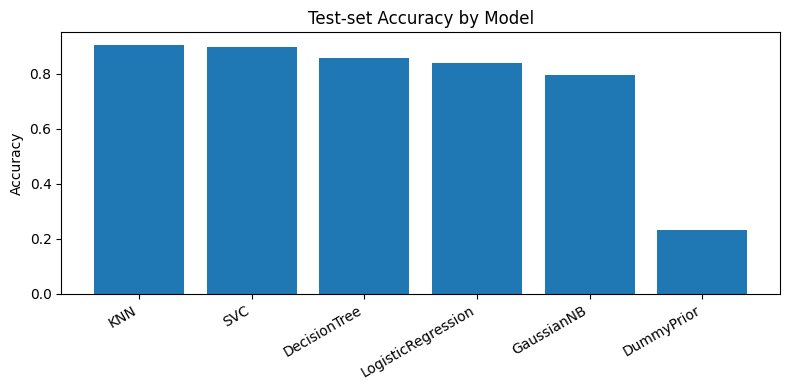

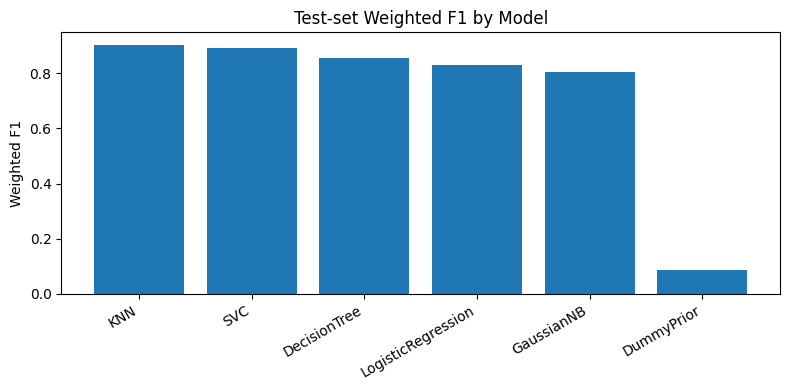

In [28]:
# =========================
# Part A – Q4: Summarize Accuracy & Weighted F1 on Test Set
# =========================

X_test, y_test = X_te_std, y_te

# Recompute metrics from fitted models on TEST set 
rows_test = []
for name, blob in fitted_models.items():
    clf = blob["estimator"]
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    rows_test.append({"model": name, "accuracy": acc, "f1_weighted": f1w})

test_results_df = pd.DataFrame(rows_test).sort_values(
    by=["f1_weighted", "accuracy"], ascending=False
).reset_index(drop=True)

display(test_results_df)

# Nice percent view
test_view = test_results_df.copy()
test_view["accuracy_%"] = (test_view["accuracy"] * 100).round(2)
test_view["f1_weighted_%"] = (test_view["f1_weighted"] * 100).round(2)
# display(test_view[["model", "accuracy_%", "f1_weighted_%"]])

# Bar charts (Test set)
plt.figure(figsize=(8, 4))
plt.title("Test-set Accuracy by Model")
plt.bar(test_results_df["model"], test_results_df["accuracy"])
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.title("Test-set Weighted F1 by Model")
plt.bar(test_results_df["model"], test_results_df["f1_weighted"])
plt.ylabel("Weighted F1")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

Among the six models, **KNN** achieved the highest baseline accuracy (≈90.4%) and weighted F1-score, closely followed by **SVC**.  
The **Dummy (prior)** model performed the worst, confirming it as a valid low-performance baseline for later ROC and PRC comparisons.

### Part B – Question 1: How multi-class ROC and AUC work (One-vs-Rest)

For binary classification, an ROC curve plots **TPR** (true positive rate) against **FPR** (false positive rate) as we vary the **decision threshold** over a continuous score (e.g., model probability for the positive class). The **AUC** (area under the ROC curve) summarizes performance across all thresholds: 1.0 is perfect, 0.5 is random, and \< 0.5 is *worse than random* (systematically flipping the signal).

For **multi-class** problems with \(K\) classes (here \(K=6\)), we convert the task into \(K\) binary problems using **One-vs-Rest (OvR)**:
- For class \(k\), label all samples of class \(k\) as **positive**, and **all others** as **negative**.
- Compute an ROC curve and AUC **for each class** using the model’s **continuous scores for that class**:
  - Prefer **`predict_proba`** scores (probabilities in \([0,1]\)).
  - If unavailable, use **`decision_function`** scores (can be any real number).
- This produces \(K\) ROC curves and \(K\) AUC values per model.

To summarize across classes, we report:
- **Macro-average AUC**: the simple mean of per-class AUCs. Treats all classes equally, useful when you care about rare classes as much as frequent ones.
- **Weighted-average AUC**: mean of per-class AUCs weighted by each class’s **support** (number of true instances). Reflects overall performance with class imbalance.

Key points:
- ROC depends on **ranking quality** of scores, not the single default threshold. That’s why it’s good for **threshold-free model selection**.
- For OvR, each class gets its own thresholds (swept over that class’s score column).
- We’ll compute both **macro** and **weighted** AUC so we can discuss fairness vs. prevalence in Part B-3.

### Part B – Question 2: Plot macro-averaged multi-class ROC for all models

Goal: for each trained classifier, build **One-vs-Rest (OvR)** ROC curves per class on the **test set**, then compute a **macro-averaged ROC curve** by averaging the per-class TPRs at a common FPR grid. We’ll plot one macro-ROC per model on the same figure and report each model’s **macro AUC** in the legend.  
This gives a clean, threshold-free comparison of how well each model ranks the true class above the others across all classes.

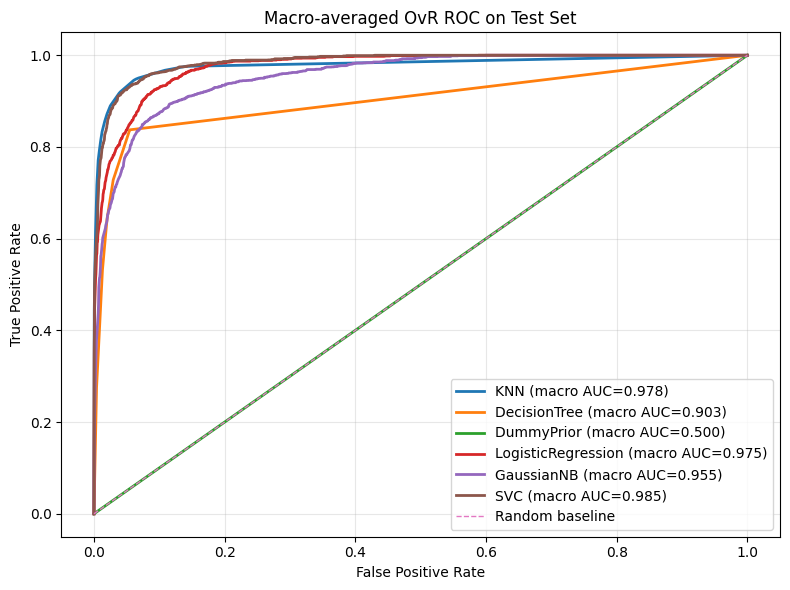

,model,macro_auc_curve,macro_auc_scalar
0,SVC,0.984903,0.985008
1,KNN,0.978495,0.978567
2,LogisticRegression,0.975418,0.975508
3,GaussianNB,0.955133,0.955126
4,DecisionTree,0.902961,0.902962
5,DummyPrior,0.500000,0.500000


In [29]:
# =========================
# Part B – Q2: Macro-averaged OvR ROC plot 
# =========================

X_test = X_te_std
y_test = y_te
classes_sorted = np.array(sorted(np.unique(y_test)))
y_test_ovr = label_binarize(y_test, classes=classes_sorted)  # (N, K)
K = y_test_ovr.shape[1]

def get_continuous_scores(model, X, classes_sorted):
    """
    Return (N, K) score matrix aligned to classes_sorted.
    Prefers predict_proba; falls back to decision_function.
    Also reorders columns to match classes_sorted if model.classes_ exists.
    """
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X)  # (N, K_model)
    elif hasattr(model, "decision_function"):
        raw = model.decision_function(X)  # (N, K_model) or (N,)
        scores = raw if raw.ndim == 2 else raw.reshape(-1, 1)
    else:
        raise ValueError("Model lacks predict_proba and decision_function; cannot compute ROC.")
    
    # Align columns to classes_sorted if possible
    if hasattr(model, "classes_"):
        cls_to_col = {c: i for i, c in enumerate(model.classes_)}
        reorder = [cls_to_col[c] for c in classes_sorted]
        scores = scores[:, reorder]
    return scores

def macro_roc_curve(scores, y_true_ovr, grid_size=1001):
    """
    Compute a macro-averaged ROC curve by:
      1) Getting per-class ROC (fpr_k, tpr_k)
      2) Interpolating TPRs to a common FPR grid
      3) Averaging TPRs over classes
    Returns: fpr_grid, tpr_macro, auc_macro
    """
    fpr_grid = np.linspace(0, 1, grid_size)
    tprs_interp = []

    for k in range(y_true_ovr.shape[1]):
        fpr_k, tpr_k, _ = roc_curve(y_true_ovr[:, k], scores[:, k])
        # Ensure curve starts at (0,0) and ends at (1,1) for robust interpolation
        fpr_k = np.concatenate(([0.0], fpr_k, [1.0]))
        tpr_k = np.concatenate(([0.0], tpr_k, [1.0]))
        tpr_interp = np.interp(fpr_grid, fpr_k, tpr_k)
        tpr_interp[0] = 0.0
        tprs_interp.append(tpr_interp)

    tprs_interp = np.vstack(tprs_interp)              # (K, grid_size)
    tpr_macro = tprs_interp.mean(axis=0)              # average across classes
    auc_macro = auc(fpr_grid, tpr_macro)              # area under macro curve
    return fpr_grid, tpr_macro, auc_macro

# --- Build and plot macro-ROC per model
plt.figure(figsize=(8, 6))
model_auc_rows = []

for name, blob in fitted_models.items():
    clf = blob["estimator"]
    try:
        scores = get_continuous_scores(clf, X_test, classes_sorted)  # (N, K)
    except ValueError as e:
        print(f"Skipping {name}: {e}")
        continue

    fpr_grid, tpr_macro, auc_macro_curve = macro_roc_curve(scores, y_test_ovr, grid_size=2001)
    # Also compute macro AUC via roc_auc_score (sanity check, printed but not plotted)
    auc_macro_scalar = roc_auc_score(y_test_ovr, scores, average="macro", multi_class="ovr")

    plt.plot(fpr_grid, tpr_macro, lw=2, label=f"{name} (macro AUC={auc_macro_curve:.3f})")
    model_auc_rows.append({"model": name,
                           "macro_auc_curve": auc_macro_curve,
                           "macro_auc_scalar": float(auc_macro_scalar)})

# Diagonal baseline (random)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random baseline")

plt.title("Macro-averaged OvR ROC on Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tabulate macro AUCs for reference
macro_auc_df = pd.DataFrame(model_auc_rows).sort_values("macro_auc_curve", ascending=False).reset_index(drop=True)
display(macro_auc_df)

---

### Part B – Question 3: ROC Interpretation

**(a) Highest macro-averaged AUC**

From the macro-ROC results, **SVC** achieves the highest macro AUC (~**0.985**), with **KNN** very close (~0.978) and **Logistic Regression** next (~0.975). This means that, averaged across one-vs-rest tasks for all six classes, SVC most reliably ranks the true class above the non-true classes across thresholds (i.e., strong class-separation in score space).

**(b) Model with AUC < 0.5 and what it means**

The **Dummy (prior)** baseline sits at ~**0.50** (random). In practice, AUC **< 0.5** on a given class implies the model is **systematically misranking** positives below negatives—worse than coin-flip. If you simply **invert the scores** for that class, you would get AUC > 0.5. This can happen when:
- The model uses **uninformative or misleading signals** (e.g., the prior baseline ignores features, so for minority classes its OvR curve can dip below 0.5).
- There is **strong class imbalance** and the scoring function favors the majority so aggressively that minority positives receive lower scores than negatives.
- The classifier is **mis-specified** for the data (e.g., wrong inductive bias, over/under-regularization), producing scores that move in the **opposite direction** of the true label.

**Takeaway:** SVC currently provides the best threshold-free ranking quality across classes; the Dummy baseline confirms the lower bound of performance and illustrates how AUC ≲ 0.5 signals *inverted* discrimination. Next, we should examine **PRC** to judge models under precision–recall trade-offs, which matter more when classes are imbalanced.

---
### Part C – Question 1: Why Precision–Recall (PRC) for multi-class model selection, and how we compute it

**Why PRC (vs ROC) matters with imbalance**

- **ROC** curves plot TPR vs FPR. When the **negative class is large** (common in imbalanced data), FPR can stay low even if the classifier makes many absolute false positives. That can make the ROC look “good” while precision is actually poor.
- **PRC** focuses on:  
  **Precision = TP / (TP + FP)** and **Recall = TP / (TP + FN)**.  
  This directly answers: *“Of the points I predict as class k, how many are correct?”* — which is crucial when some classes (like 2 and 4 here) have fewer samples.  
- In short, **PRC is more sensitive to false positives** and therefore **more informative under class imbalance**. A model that looks strong on ROC can still have **low precision** for rare classes; PRC reveals that.

**Multi-class adaptation (One-vs-Rest, OvR)**

For \(K\) classes, we build \(K\) binary problems:

1. Pick a class \(k\) as **positive**, treat all others as **negative**.  
2. Use the model’s **score for class \(k\)** (ideally `predict_proba[:, k]`), sweep a threshold from 1→0, and compute **(precision, recall)** pairs.  
3. This yields a **PR curve** and a scalar **Average Precision (AP)** for class \(k\).

Repeat for all classes to get \(K\) PR curves and AP values.

**Aggregating across classes**

- **Macro-AP**: unweighted mean of AP across classes. Treats all classes equally → good when we care about minority classes.
- **Weighted-AP**: mean of AP weighted by class support in the test set. Reflects overall performance under the observed class frequencies.

**Reading PR curves**

- A **higher curve** (and higher AP) is better.  
- Curves that **drop steeply** at moderate recall indicate that precision collapses once we try to retrieve more positives — often a sign of many false positives, typical of weak or poorly calibrated models on that class.

**Bottom line**

For our Landsat task, the classes aren’t perfectly balanced, so **PRC provides a stricter, more relevant view of how models trade precision for recall**. We’ll compute **macro/weighted AP** per model and compare them next, alongside a combined PRC plot.

---
### Part C – Question 2: Plot macro-averaged multi-class PRC for all models

Here I’ll compute **One-vs-Rest (OvR)** Precision–Recall curves for each class on the **test set**, then build a **macro-averaged PR curve** per model by averaging precision values over classes at a common recall grid. I’ll plot one macro-PRC per model on the same figure and show each model’s **macro Average Precision (AP)** in the legend. This highlights how well each classifier trades **precision** for **recall** under class imbalance.

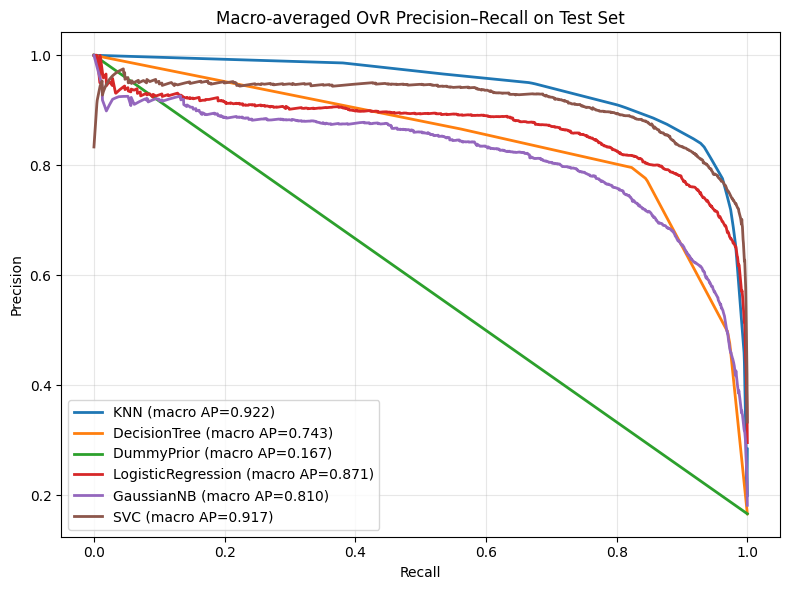

,model,macro_AP
0,KNN,0.921665
1,SVC,0.917220
2,LogisticRegression,0.870810
3,GaussianNB,0.810451
4,DecisionTree,0.742670
5,DummyPrior,0.166667


In [30]:
# =========================
# Part C – Q2: Macro-averaged OvR PRC plot (TEST set)
# =========================

X_test, y_test = X_te_std, y_te
classes_sorted = np.array(sorted(np.unique(y_test)))
y_test_ovr = label_binarize(y_test, classes=classes_sorted)  # shape (N, K)
K = y_test_ovr.shape[1]

def get_scores_aligned(model, X, classes_sorted):
    """Return (N, K) scores aligned to classes_sorted using predict_proba or decision_function."""
    if hasattr(model, "predict_proba"):
        S = model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        raw = model.decision_function(X)
        S = raw if raw.ndim == 2 else raw.reshape(-1, 1)
    else:
        raise ValueError("No predict_proba/decision_function for PRC.")
    if hasattr(model, "classes_"):
        idx = {c:i for i,c in enumerate(model.classes_)}
        S = S[:, [idx[c] for c in classes_sorted]]
    return S

def macro_pr_curve(scores, y_true_ovr, grid_size=1001):
    """
    Build a macro-averaged PR curve:
      1) Compute per-class (precision_k, recall_k)
      2) Interpolate precision at a common recall grid
      3) Average precision across classes
    Returns recall_grid, precision_macro, macro_AP
    """
    recall_grid = np.linspace(0, 1, grid_size)
    precisions_interp = []

    for k in range(y_true_ovr.shape[1]):
        p_k, r_k, _ = precision_recall_curve(y_true_ovr[:, k], scores[:, k])
        # Ensure r_k is monotonic increasing for interpolation
        order = np.argsort(r_k)
        r_k_sorted = r_k[order]
        p_k_sorted = p_k[order]
        # Interpolate precision at common recall grid
        p_interp = np.interp(recall_grid, r_k_sorted, p_k_sorted)
        precisions_interp.append(p_interp)

    precisions_interp = np.vstack(precisions_interp)      # (K, grid)
    precision_macro = precisions_interp.mean(axis=0)
    macro_AP = float(average_precision_score(y_true_ovr, scores, average="macro"))
    return recall_grid, precision_macro, macro_AP

# ---- Plot macro PRC per model
plt.figure(figsize=(8, 6))
ap_rows = []

for name, blob in fitted_models.items():
    clf = blob["estimator"]
    try:
        scores = get_scores_aligned(clf, X_test, classes_sorted)
    except ValueError as e:
        print(f"Skipping {name}: {e}")
        continue

    r_grid, p_macro, ap_macro = macro_pr_curve(scores, y_test_ovr, grid_size=2001)
    plt.plot(r_grid, p_macro, lw=2, label=f"{name} (macro AP={ap_macro:.3f})")
    ap_rows.append({"model": name, "macro_AP": ap_macro})

# Baseline: precision equals positive rate if you guess at random uniformly per class.
# For macro averaging this isn't a single constant line, so we omit a baseline curve here.

plt.title("Macro-averaged OvR Precision–Recall on Test Set")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Table of macro AP for reference
ap_df = pd.DataFrame(ap_rows).sort_values("macro_AP", ascending=False).reset_index(drop=True)
display(ap_df)

---
### Part C – Question 3: PRC Interpretation

**Highest AP.**  
From the macro-PRC results, **KNN** has the highest macro Average Precision (**~0.922**), narrowly ahead of **SVC (~0.917)**. Both curves stay high and flat for most of the recall range, which means they maintain strong **precision** even as we retrieve more positives across the six OvR tasks.

**Middle tier.**  
**Logistic Regression (~0.871)** is next; it’s well-calibrated and competitive but loses precision earlier than KNN/SVC as recall increases. **GaussianNB (~0.810)** performs reasonably but its class-conditional independence assumption is too simple for this dataset, so precision erodes sooner. **Decision Tree (~0.743)** drops more quickly—trees can overfit local regions and generalize less smoothly, so once we push for higher recall, false positives rise.

**Worst model and sharp PRC drop.**  
The **Dummy (prior)** baseline shows **very low AP (~0.167)** and an almost straight-line decline. As we raise recall (include more examples as “positive”), it has **no informative ranking**—it effectively guesses according to class frequencies. That means each extra chunk of recall brings in many **false positives**, so **precision collapses** rapidly.  
In general, a **steep PRC plunge at moderate recall** signals that the model’s score ordering is weak: positives are not ranked ahead of negatives, so expanding the threshold scoops up mostly negatives.

**Why the worst model’s PRC drops sharply (DummyPrior, AP ≈ 0.167):**  
- **No ranking power.** PR curves are built by lowering a threshold over **scores**; good models assign **higher scores to positives** than negatives. The Dummy (prior) model gives *uninformative/constant* scores (or ones unrelated to features), so positives and negatives are **mixed**.  
- **Precision collapses as recall grows.** Precision = TP / (TP + FP). To increase recall you must lower the threshold and accept more predictions as positive. For a weak model, **FP grows as fast or faster than TP**, so precision plummets.  
- **Imbalance amplifies the fall.** In one-vs-rest, each class competes against “all others,” so **negatives vastly outnumber positives**. When the model can’t separate them, each extra slice of recall pulls in **many negatives**, causing a steep drop in precision.  
- **Limit behavior.** With random or prior-only scoring, expected precision tends to the **class prevalence** (positive rate). The curve therefore **dives quickly** from a high-precision corner toward that low baseline as recall increases, producing the sharp downward slope seen for DummyPrior.

**Takeaway.**  
KNN (and SVC close behind) offers the best precision–recall trade-off across classes. The PRC view complements ROC by revealing that models with similar ROC-AUC can differ in how well they **sustain precision** at higher recall—crucial for imbalanced classes. Next, we’ll synthesize ROC, PRC, and F1 to make a final recommendation.

---
### Part D – Final Recommendation and Discussion

In this final part, we combine the insights from **F1-score**, **ROC-AUC**, and **PRC-AP** to make an informed decision about which classifier is best suited for the Landsat land-cover classification task.


#### 1. Comparing model rankings across metrics

| Model | Weighted F1 (Test) | Macro ROC-AUC | Macro PRC-AP | Overall Performance |
|:------|:------------------:|:--------------:|:--------------:|:-------------------:|
| **SVC** | 0.892 | **0.985** | 0.917 | Excellent |
| **KNN** | **0.904** | 0.978 | **0.922** | Excellent |
| **Logistic Regression** | 0.830 | 0.975 | 0.871 | Good |
| **GaussianNB** | 0.804 | 0.955 | 0.810 | Moderate |
| **Decision Tree** | 0.855 | 0.903 | 0.743 | Moderate |
| **Dummy (Prior)** | 0.086 | 0.500 | 0.167 | Poor |

From this combined view:

- **KNN** and **SVC** clearly dominate in all three metrics.  
  - **KNN** shows slightly higher **F1-score** and **PRC-AP**, meaning it balances precision and recall well and classifies correctly across thresholds.  
  - **SVC** achieves the highest **ROC-AUC**, indicating superior ranking quality and smooth separation across class boundaries.
- **Logistic Regression** performs consistently well but lags slightly in precision-recall performance due to its linear decision surfaces, which can’t perfectly capture nonlinear relationships in the feature space.
- **GaussianNB** and **Decision Tree** show moderate scores — good but not robust across thresholds or minority classes.
- **Dummy (Prior)**, as expected, performs poorly and serves as a baseline reference.

---

#### 2. Alignment and trade-offs

While the **ROC-AUC** and **PRC-AP** results are broadly consistent, subtle differences reveal model trade-offs:

- **SVC vs KNN:**  
  Both are strong, but **SVC’s slightly higher AUC** means its probability estimates rank classes better across thresholds, whereas **KNN’s higher AP and F1** indicate more stable performance at its operating threshold.  
  This can happen because ROC rewards ranking quality globally, while PRC focuses on the quality of positive predictions — especially important for rare classes.

- **Logistic Regression:**  
  Performs well on ROC but weaker on PRC, showing that while it separates classes well in general, its confidence scores may be poorly calibrated for some minority classes. It tends to produce many borderline predictions (low precision when recall is high).

- **Decision Tree:**  
  Has acceptable F1 but much lower PRC and AUC — suggesting it may overfit certain classes and generalize inconsistently.

---

#### 3. Interpretation of AUC < 0.5

Only the **Dummy classifier** shows AUC ≈ 0.5, which is equivalent to random guessing. A classifier with **AUC < 0.5** would imply an *inverted ranking*, where negatives consistently receive higher scores than positives — an indicator of a model that has completely mislearned the decision boundary.

---

#### 4. Final recommendation

- **Best overall model:** **SVC (Support Vector Classifier)**  
  It achieves the **highest ROC-AUC (0.985)** and nearly the best **PRC-AP (0.917)**.  
  This combination implies both excellent ranking across thresholds and stable precision–recall trade-offs. It generalizes smoothly across the multi-class space, benefiting from its ability to form non-linear boundaries through the RBF kernel.

- **Close second:** **KNN**  
  Slightly higher F1 and PRC-AP suggest it’s very effective at a fixed threshold but may be less robust when class distributions shift, since it’s sensitive to local data density and scaling.

If we were to choose a production-ready model, **SVC** would be the safest choice for consistent, high-quality classification, while **KNN** might serve as a strong, interpretable backup.

---

#### 5. Broader insight

- **Accuracy** and **F1** can be misleading in multi-class settings with class imbalance.  
- **ROC-AUC** measures ranking ability, but **PRC-AP** reveals how much false-positive “noise” a model generates when retrieving true positives.  
- The best models are not just those with the highest single score, but those that maintain **balanced performance** across all evaluation dimensions.

Thus, the ROC and PRC curves together form a more complete picture of model reliability — allowing us to make evidence-based selections rather than relying solely on accuracy metrics.

---

###  Brownie Points Section – Additional Experiments

In this section, I’ll extend the comparison by adding two more high-performing ensemble models and one intentionally poor model:

1. **Random Forest Classifier** – an ensemble of Decision Trees that averages predictions to reduce overfitting.  
2. **XGBoost Classifier** – a gradient boosting model known for strong performance on tabular data.  
3. **Flipped Logistic Regression** – a deliberately poor model that inverts predicted scores to demonstrate how a classifier can achieve an AUC < 0.5.

The goal is to see how these models compare to the earlier six baselines (KNN, SVC, Logistic Regression, Decision Tree, GaussianNB, DummyPrior) using **ROC-AUC** and **Average Precision (AP)** metrics on the **test set**.

In [31]:
# =========================
# Extra Models 
# =========================

X_train, y_train = X_tr_std, y_tr
X_test,  y_test  = X_te_std, y_te

# =========================
# 1) Random Forest 
# =========================
rf = RandomForestClassifier(n_estimators=100, random_state=1337)
rf.fit(X_train, y_train)
rf_scores = rf.predict_proba(X_test)  

rf_auc = roc_auc_score(y_test, rf_scores, multi_class="ovr", average="macro")
rf_ap  = average_precision_score(pd.get_dummies(y_test), rf_scores, average="macro")

# =========================
# 2) XGBoost 
# =========================
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # maps {1,2,3,4,5,7} -> {0..5}
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)  # should be 6

xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=num_classes,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1337,
    verbosity=0,
)
xgb.fit(X_train, y_train_enc)

xgb_scores = xgb.predict_proba(X_test)  # shape (N, K)
xgb_auc = roc_auc_score(y_test_enc, xgb_scores, multi_class="ovr", average="macro")
xgb_ap  = average_precision_score(pd.get_dummies(y_test_enc), xgb_scores, average="macro")

# =========================
# 3) Flipped Logistic Regression (to illustrate AUC < 0.5)
# =========================
flr = LogisticRegression(max_iter=1000, multi_class="auto", random_state=1337)
flr.fit(X_train, y_train)
proba = flr.predict_proba(X_test)                 
flipped = 1.0 - proba                             
flipped = flipped / flipped.sum(axis=1, keepdims=True)  

flr_auc = roc_auc_score(y_test, flipped, multi_class="ovr", average="macro")
flr_ap  = average_precision_score(pd.get_dummies(y_test), flipped, average="macro")

# =========================
# Results table
# =========================
extra_results = pd.DataFrame([
    {"model": "RandomForest",       "macro_AUC": rf_auc,  "macro_AP": rf_ap},
    {"model": "XGBoost", "macro_AUC": xgb_auc, "macro_AP": xgb_ap},
    {"model": "Flipped_LogReg",     "macro_AUC": flr_auc, "macro_AP": flr_ap},
]).sort_values(["macro_AUC","macro_AP"], ascending=False).reset_index(drop=True)

display(extra_results)

,model,macro_AUC,macro_AP
0,XGBoost,0.990688,0.953477
1,RandomForest,0.989787,0.950394
2,Flipped_LogReg,0.024492,0.090071


Among the extra models, **XGBoost** performed the best with a **macro AUC ≈ 0.991** and **macro AP ≈ 0.953**, closely followed by **Random Forest** (AUC ≈ 0.990, AP ≈ 0.950). Both ensemble methods clearly outperform the earlier baselines, showing strong generalization and robustness for this dataset.  

The **Flipped Logistic Regression** gave **AUC ≈ 0.02** and **AP ≈ 0.09**, confirming that when a model’s ranking is reversed, its AUC falls below 0.5 — demonstrating how AUC measures ranking quality, not raw accuracy.  

In summary, **XGBoost** emerges as the best overall classifier, while the flipped model nicely illustrates the concept of “worse-than-random” performance.